====================================================================================================
# **Análisis del P300-Dataset & DrugSignal.py** 
#### **(Después le agrego un subtítulo)**

https://www.kaggle.com/datasets/rramele/p300samplingdataset

Docente: Rodrigo Ramele | rramele@itba.edu.ar  
Estudiante: Alexander Chavez | achavezmontano@itba.edu.ar  
====================================================================================================

### 0. Información introductoria
- ERPs (Event-related potential):   
Respuesta positiva: P300 (300ms | 5uV), P600 (600ms | 4uV)  
Respuesta negativa: ERN(200ms | 3,75uV), N400 (400ms | 5uV)  
Los tiempos indican el delay cuando el ERP ocurre después del evento.
Son de baja amplitud.

- *MNE: Open-source Python package for exploring, visualizing, and analyzing human neurophysiological data: MEG, EEG, sEEG, ECoG, NIRS, and more.*
*The function loadmat loads all variables stored in the MAT-file into a simple Python data structure, using only Python’s dict and list objects.* 
*Numeric and cell arrays are converted to row-ordered nested lists. Arrays are squeezed to eliminate arrays with only one element.* 
*The resulting data structure is composed of simple types that are compatible with the JSON format.*

- Paradigma de Oddball: https://en.wikipedia.org/wiki/Oddball_paradigm

- EEG -> Estocástica, no estacionaria, multicanal.


### 1. Instalar e importar librerías

In [1]:
import mne                                                              # pip install mne
mne.set_log_level('WARNING')                                            # Luego averiguar ¿para qué?
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb                                                    # Por ahora lo voy a usar para cambiar los nombres de las columnas
color = ['green', 'blue','red','cyan', 'magenta', 'yellow','k','w']     # Paleta de colores para diferenciar las ondas

### 1.a. Mis funciones

In [2]:
def to_df(no_df):
    df = pd.DataFrame(no_df) 
    df['sample'] = df.index
    return df

### 2. Carga de archivos
Se cargan tres señales, una modelo y dos ERPs de pacientes de 29 años, hombres.  
Para el caso del ERPTemplate ahí está la info de los canales.  
Para los archivos P300S04 y P300S07 es distinto.  
El archivo .mat contiene una estructura de datos cuya info importante para éste trabajo es el 'routput'.  


In [4]:
# First load the template.  This is the signal that will be used to DRUG the basal EEG stream.
mat = scipy.io.loadmat('./dataset/ERPTemplate.mat') 
mat4 = scipy.io.loadmat('./dataset/P300S04.mat')                        # Carga de dos P300. Ambos pacientes de 29 años, hombres. 
mat7 = scipy.io.loadmat('./dataset/P300S07.mat')   

In [60]:
#mat

### 2.1. Revisión de la estructura de datos de P300S04.mat
Son levemente distintas al ERPTemplate.mat  
  
'header' -> Info general del MAT-file.  
'version' -> 1.0.  
'globals' -> Vacío.  
  
'channelRange' -> Un array con los 8 canales. Si los querés tratar, los separás en un df.  
'Fs' > La Fs, frecuencua de muestreo: 250.  
'Trials' -> Sample point where each of the 35 trials starts. (HAY QUE REPASAR ESTO)  
'stims' -> 21482 rows × 3 columns, data.y_stim: Stimulation number: 1-6 rows, 7-12 cols.  
'channelNames' -> Etiqueta de cada uno de los 8 canales: # [FZ]	[CZ] [P3] [PZ] [P4]	[PO7] [PO8]	[OZ]  
'sampleTime' -> 355872 rows × 1 columns, (NO SE QUE ES)  
'samples' -> Acá hay una señal, no es un P300 como tal pero está.  
'Word'  
'data' -> El [0][0][0] lo usa Rodrigo para trabajar mas adelante.

In [5]:
df_mat4_channelRange = pd.DataFrame(mat4['channelRange'])
df_mat4_Fs = pd.DataFrame(mat4['Fs'])
df_mat4_Trials = pd.DataFrame(mat4['Trials'])
df_mat4_stims = pd.DataFrame(mat4['stims'])
df_mat4_channelNames = pd.DataFrame(mat4['channelNames'])
df_mat4_sampleTime = pd.DataFrame(mat4['sampleTime'])
df_mat4_samples = pd.DataFrame(mat4['samples'])
df_mat4_data = pd.DataFrame(mat4['data'][0][0][0]) 
df_mat4_subject = pd.DataFrame(mat4['subject'])

##### *Grafico todo 'samples', o 'data' en una misma imagen:*

In [6]:
#df_mat4_data.columns = ['FZ', 'CZ', 'P3', 'PZ', 'P4', 'P07', 'PO8', 'OZ'] #(OJO, SI LO AGREGO NO HACE EL FOR ABAJO)
df_mat4_data['index'] = df_mat4_data.index
#df_mat4_samples.columns = ['FZ', 'CZ', 'P3', 'PZ', 'P4', 'P07', 'PO8', 'OZ'] #(OJO, SI LO AGREGO NO HACE EL FOR ABAJO)
df_mat4_samples['index'] = df_mat4_samples.index
channelNames = ['FZ', 'CZ', 'P3', 'PZ', 'P4', 'P07', 'PO8', 'OZ','index']

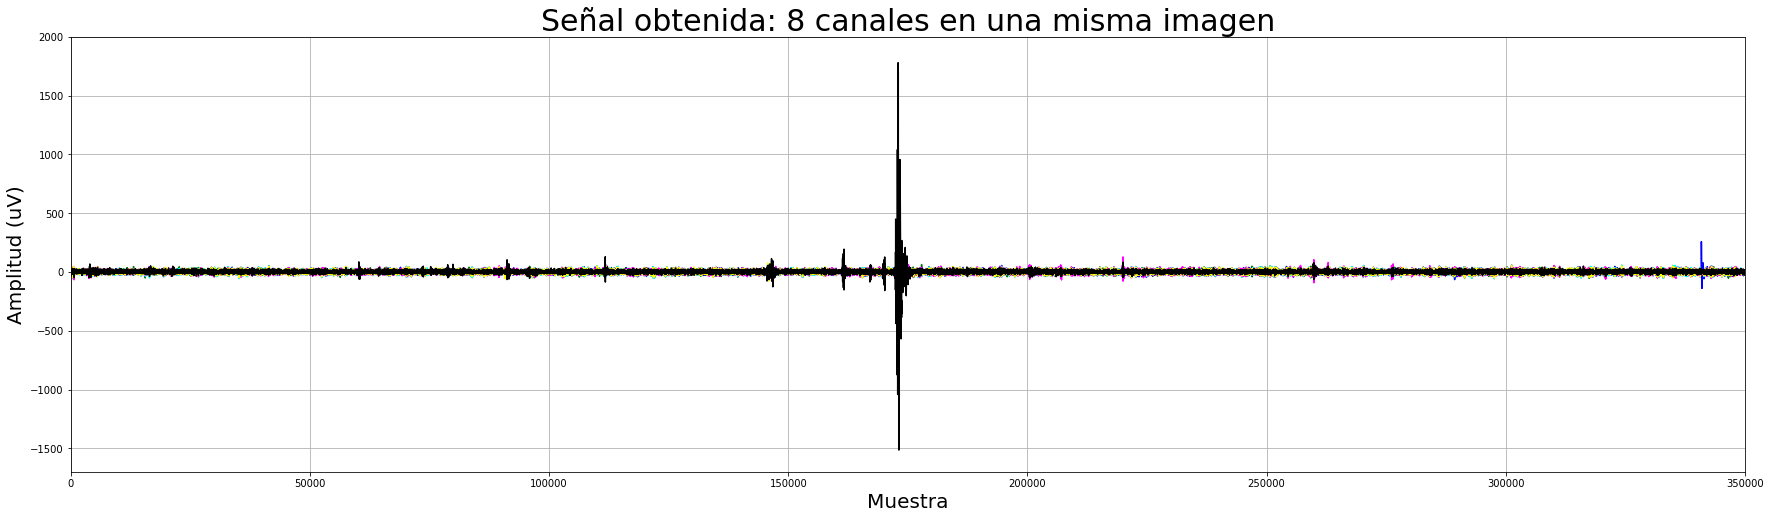

In [48]:
plt.figure(figsize=(30,8))
axes = plt.gca()
for i in range(0,7):
    plt.plot(df_mat4_data['index'], df_mat4_data[i], color[i])
axes.set_title('Señal obtenida: 8 canales en una misma imagen')
axes.set_xlabel('Muestra')
axes.set_ylabel('Amplitud (uV)')
axes.title.set_size(30)
axes.xaxis.label.set_size(20)
axes.yaxis.label.set_size(20)
plt.axis((0,350000,-1700,2000))
plt.grid()
plt.savefig("./images_alex/01 - P300S04 - 8 Canales.jpg")
plt.show()


##### *Hago un "describe" para ver las cotas de cada una de las ondas*

In [49]:
df_mat4_data.describe()

,0,1,2,3,4,5,6,7,index
count,355872.000000,355872.000000,355872.000000,355872.000000,355872.000000,355872.000000,355872.000000,355872.000000,355872.000000
mean,0.000836,-0.000006,0.000553,0.002417,-0.000547,0.000525,0.011254,-0.000133,177935.500000
std,9.943149,11.074504,10.997419,11.179263,10.862208,10.032820,40.343403,8.228174,102731.541836
min,-70.646057,-137.649551,-61.142323,-61.047009,-91.708542,-78.050255,-1514.828491,-67.566948,0.000000
25%,-6.355463,-7.009691,-7.123110,-7.234213,-6.735395,-6.481792,-5.128433,-5.322606,88967.750000
50%,-0.054990,-0.038295,-0.134003,-0.096321,-0.080122,-0.163862,-0.188941,-0.370402,177935.500000
75%,6.362632,6.894224,6.991487,7.111699,6.670920,6.266195,4.888881,4.788723,266903.250000
max,63.589142,258.674927,59.404602,60.456150,128.368011,77.115242,1780.421020,91.254089,355871.000000


##### *Grafico todo 'data' en imágenes separadas. Las primeras 3:*

PENDIENTE HACER UNA FUNCION DE GRAFICAS

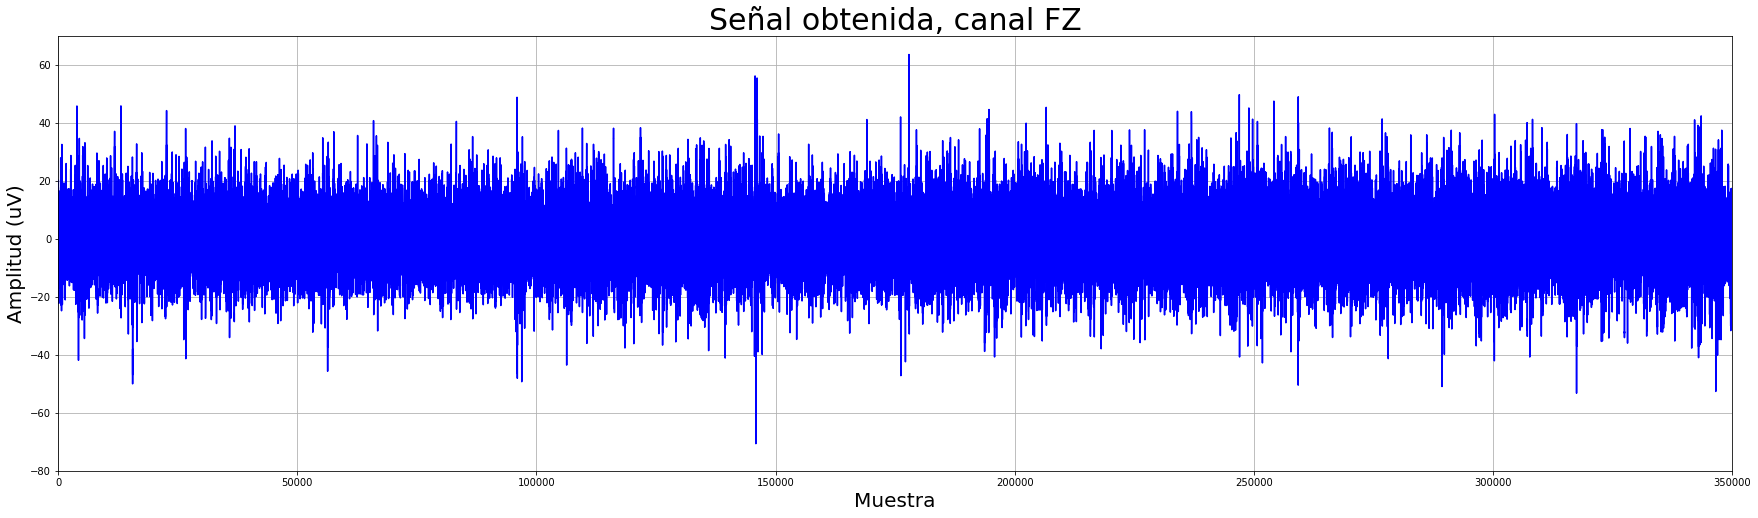

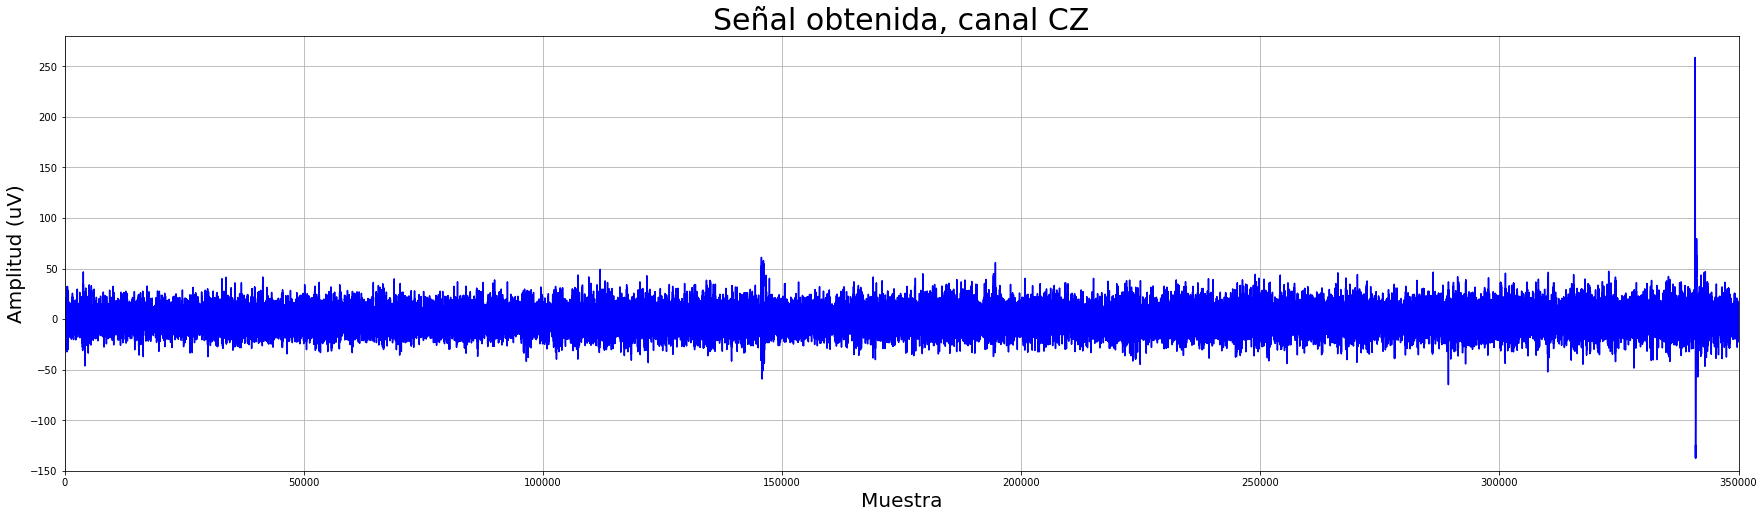

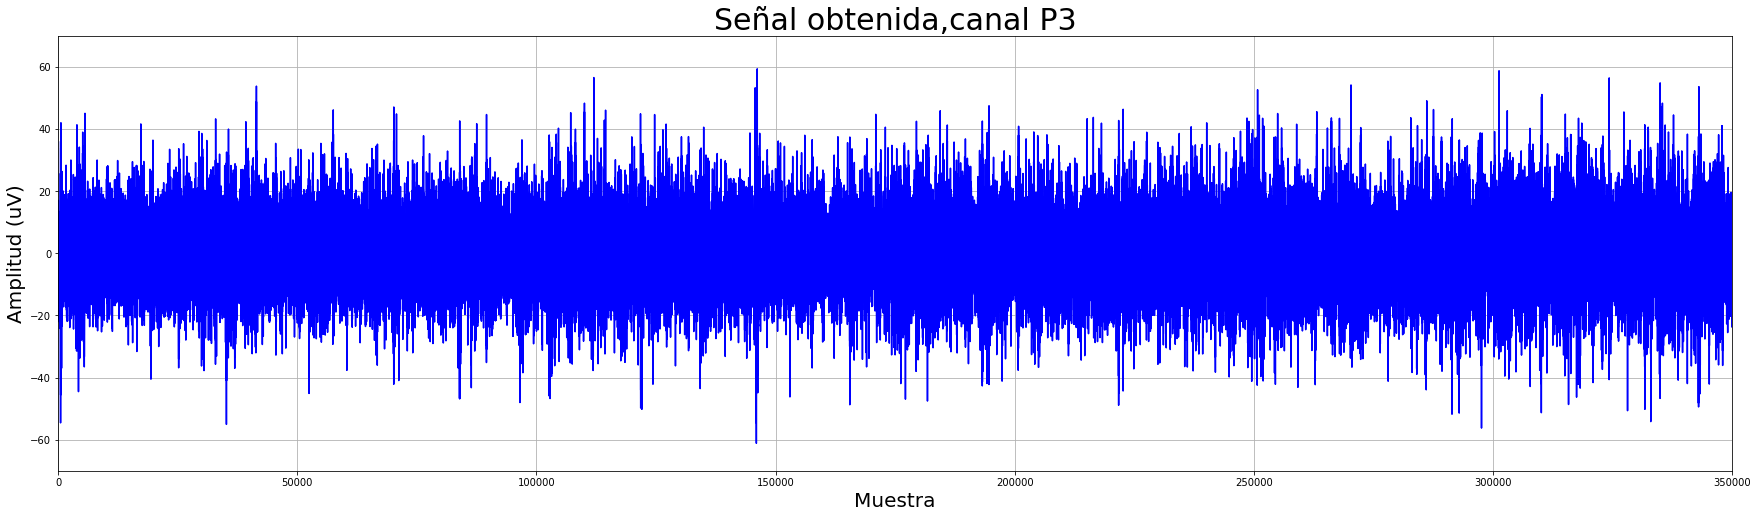

In [54]:
plt.figure(figsize=(30,8))
axes = plt.gca()
plt.plot(df_mat4_data['index'], df_mat4_data[0], color[1])
axes.set_title('Señal obtenida, canal FZ')
axes.set_xlabel('Muestra')
axes.set_ylabel('Amplitud (uV)')
axes.title.set_size(30)
axes.xaxis.label.set_size(20)
axes.yaxis.label.set_size(20)
plt.axis((0,350000,-80,70))
plt.grid()
plt.savefig("./images_alex/02 - P300S04_ChFZ.jpg")
plt.show()
#------------------------------
plt.figure(figsize=(30,8))
axes = plt.gca()
plt.plot(df_mat4_data['index'], df_mat4_data[1], color[1])
axes.set_title('Señal obtenida, canal CZ')
axes.set_xlabel('Muestra')
axes.set_ylabel('Amplitud (uV)')
axes.title.set_size(30)
axes.xaxis.label.set_size(20)
axes.yaxis.label.set_size(20)
plt.axis((0,350000,-150,280))
plt.grid()
plt.savefig("./images_alex/03- P300S04_ChCZ.jpg")
plt.show()
#------------------------------
plt.figure(figsize=(30,8))
axes = plt.gca()
plt.plot(df_mat4_data['index'], df_mat4_data[2], color[1])
axes.set_title('Señal obtenida,canal P3')
axes.set_xlabel('Muestra')
axes.set_ylabel('Amplitud (uV)')
axes.title.set_size(30)
axes.xaxis.label.set_size(20)
axes.yaxis.label.set_size(20)
plt.axis((0,350000,-70,70))
plt.grid()
plt.savefig("./images_alex/04- P300S04_ChP3.jpg")
plt.show()

### 2.1. Revisión de la estructura de datos de ERPTemplate.mat
ERPTemplate.mat NO contiene toda la información de P300S04.mat,  
sólo un encabezado similar:  
    'header' -> Info general del MAT-file.  
    'version' -> 1.0.  
    'globals' -> Vacío.  
y el 'routput' que es la salida.

In [67]:
#Informativo
print("1. Encabezado : ", sorted(mat))
print("2. Tipo : ", type(mat))

1. Encabezado :  ['__globals__', '__header__', '__version__', 'routput']
2. Tipo :  <class 'dict'>


In [7]:
routput = mat['routput']
print("----------------------------------------")
print("routput")
print("----------------------------------------")
print("1. Tipo : ", type(routput))
print("2. ¿Cómo deben leerse? : ", routput.dtype) 
# dtype describes how the bytes in the fixed-size block of memory corresponding to an array item should be interpreted.
print("3. Tamaño: ", routput.size)
print("4. Forma:", routput.shape)
print("----------------------------------------")

----------------------------------------
routput
----------------------------------------
1. Tipo :  <class 'numpy.ndarray'>
2. ¿Cómo deben leerse? :  object
3. Tamaño:  8
4. Forma: (1, 8)
----------------------------------------


In [8]:
# In this ERPTemplate, there are two different template signals that are good.
erptemplate1 = routput[0][7][0][1][0][0][0][7] 
erptemplate2 = routput[0][7][0][1][0][0][0][0]

In [12]:
#print("----------------------------------------")
#print("erptemplate1")
#print("----------------------------------------")
#print("1. Tipo : ", type(erptemplate1))
#print("2. ¿Cómo deben leerse?* : ", erptemplate1.dtype) 
#print("3. Tamaño: ", erptemplate1.size)
#print("4. Forma:", erptemplate1.shape)
#print("----------------------------------------")

In [9]:
# The original ERPTemplate dataset has a sampling frequency of 256 so I need to perform a small downsampling to 250 Hz
erptemplate1 = np.delete( erptemplate1, range(0,256,43),0)
erptemplate2 = np.delete( erptemplate2, range(0,256,43),0)

*Acá los transformo en datasets y los grafico para ir siguiendo lo que contienen*

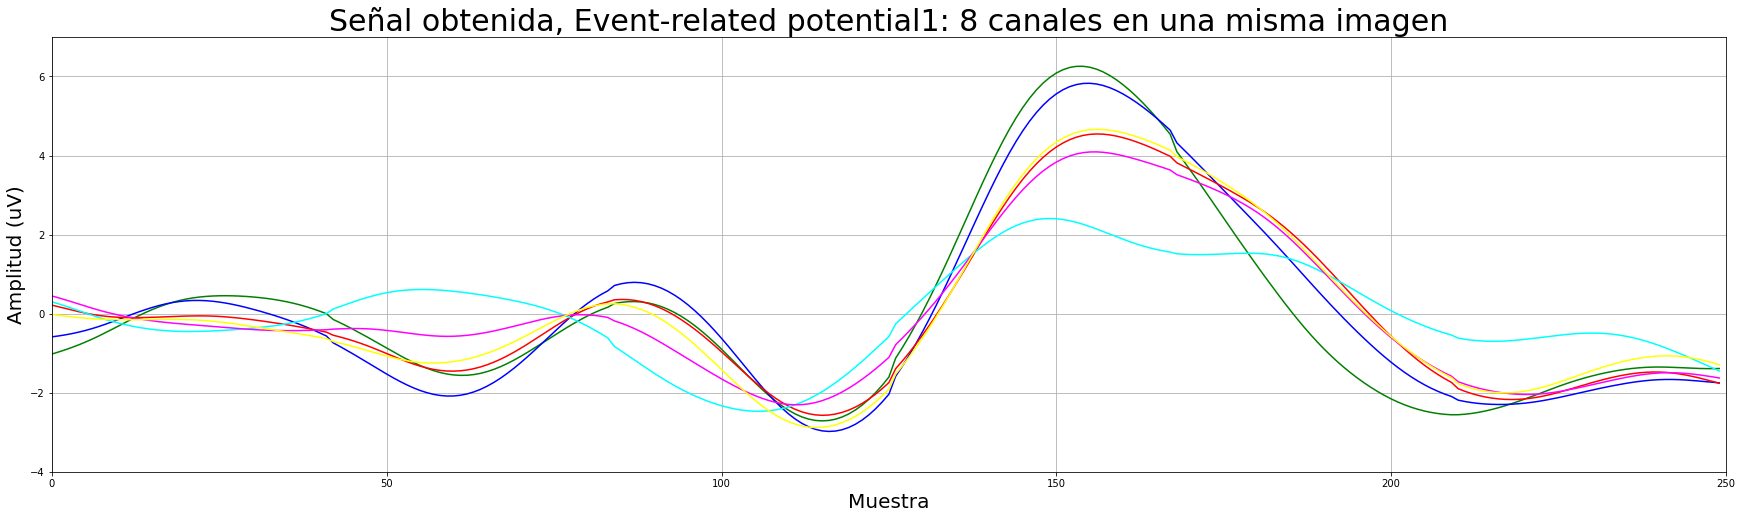

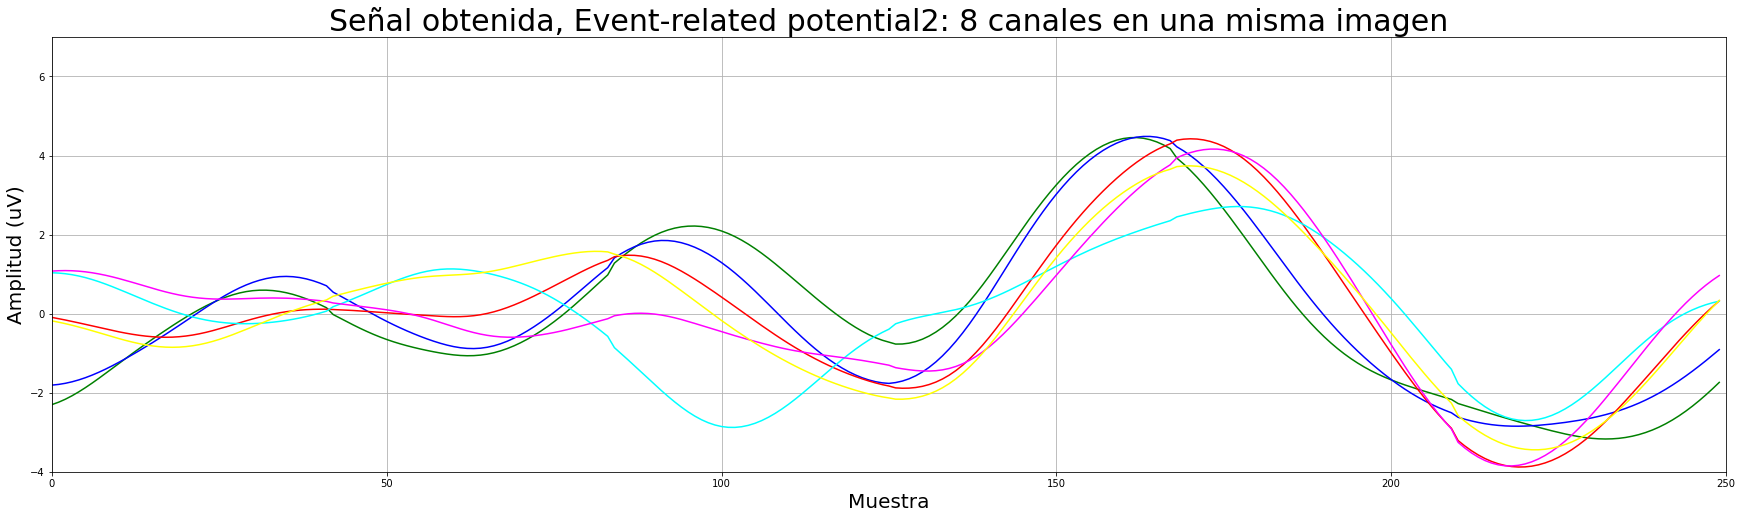

In [10]:
df_erptemplate1 = to_df(erptemplate1)
df_erptemplate2 = to_df(erptemplate2)

#df_erptemplate1 = pd.DataFrame(erptemplate1)
#df_erptemplate1['sample'] = df_erptemplate1.index
#df_erptemplate2 = pd.DataFrame(erptemplate2)
#df_erptemplate2['sample'] = df_erptemplate2.index
#df_erptemplate1.head(3)

plt.figure(figsize=(30,8))
axes = plt.gca()
for i in range(0,6):
    plt.plot(df_erptemplate1['sample'], df_erptemplate1[i], color[i])
axes.set_title('Señal obtenida, Event-related potential1: 8 canales en una misma imagen')
axes.set_xlabel('Muestra')
axes.set_ylabel('Amplitud (uV)')
axes.title.set_size(30)
axes.xaxis.label.set_size(20)
axes.yaxis.label.set_size(20)
plt.axis((0,250,-4,7))
plt.grid()
plt.savefig("05 - ERPTemplate01.jpg")
plt.show()

plt.figure(figsize=(30,8))
axes = plt.gca()
for i in range(0,6):
    plt.plot(df_erptemplate2['sample'], df_erptemplate2[i], color[i])
axes.set_title('Señal obtenida, Event-related potential2: 8 canales en una misma imagen')
axes.set_xlabel('Muestra')
axes.set_ylabel('Amplitud (uV)')
axes.title.set_size(30)
axes.xaxis.label.set_size(20)
axes.yaxis.label.set_size(20)
plt.axis((0,250,-4,7))
plt.grid()
plt.savefig("06 - ERPTemplate02.jpg")
plt.show()

In [6]:
# Use this for testing  (get a ZERO signal)
erptemplate_zeros = np.zeros((250,8))
#erptemplate_zeros
#df_erptemplate_zeros = pd.DataFrame(erptemplate_zeros)
#df_erptemplate1['sample'] = df_erptemplate_alex.index
#df_erptemplate_zeros.head(3)

In [71]:
# Randomize amplitude and jitter.
# Find the right locations where this should be inserted in the stream.
# Insert the signal mantaining the continiuity of the EEG.
def DrugSignal(signal, t_flash):
    '''
    Randomize amplitude and jitter
    Find the right locations where this should be inserted in the stream
    Insert the template mantaining the continuity and physiological meaning of the EEG
    '''
    for i in range(0,4200):
        if (t_flash[i,3]==2):
            signal[t_flash[i,0]-1:t_flash[i,0]+250-1,:] += (erptemplate1*3)

    return signal

# DRUG SIGNAL ALEX

In [72]:
def DrugSignal_ALEX(signal, t_flash):
    '''
    Randomize amplitude and jitter
    Find the right locations where this should be inserted in the stream
    Insert the template mantaining the continuity and physiological meaning of the EEG
    '''
    for i in range(0,4200):
        if (t_flash[i,3]==2):
            #signal[t_flash[i,0]-1:t_flash[i,0]+250-1,:] += (erptemplate1*3)
            signal[t_flash[i,0]-1:t_flash[i,0]+250-1,:] += (erptemplate1*3)
    return signal

In [4]:
# Now load the basal EEG stream
mat = scipy.io.loadmat('./dataset/p300-subject-25.mat')
# Lo cargo a mi manera:
mat25 = scipy.io.loadmat('./dataset/p300-subject-25.mat')
#mat = scipy.io.loadmat('./dataset/p300-subject-26.mat')
#mat = scipy.io.loadmat('/Users/rramele/./GoogleDrive/Data/P300/p300-subject-21.mat')
#mat = scipy.io.loadmat('/Users/rramele/./GoogleDrive/Data/P300/p300-subject-06.mat')
#mat

*Basal EEG activity: the EEG is the compound summation of myriads of electrical sources from
the CNS. These sources generate a baseline EEG which shows continuous activity with a small or
null relation with any concurrent cognitive activity or task.*

In [80]:
# coding: latin-1
# Data point zero for the eight channels.  Should be in V.
signal = mat['data'][0][0][0]
signal_original = mat['data'][0][0][0]
df_mat25_data = pd.DataFrame(mat25['data'][0][0][0]) 

#* pow(10,6)

In [81]:
df_mat25_data['sample'] = df_mat25_data.index
df_mat25_data.head(3)

,0,1,2,3,4,5,6,7,sample
0,-25.841171,-10.557603,-6.211982,-15.843910,-13.558990,20.122635,-11.946080,6.265652,0
1,-34.338673,-18.944792,-17.603668,-26.940290,-23.392313,-17.507841,-31.759108,-16.000412,1
2,-37.689247,-19.064447,-18.308565,-25.747719,-21.724098,-18.072618,-28.811285,-11.629916,2


In [82]:
df_signal_original = to_df(signal_original) 
#df_signal_original.describe()

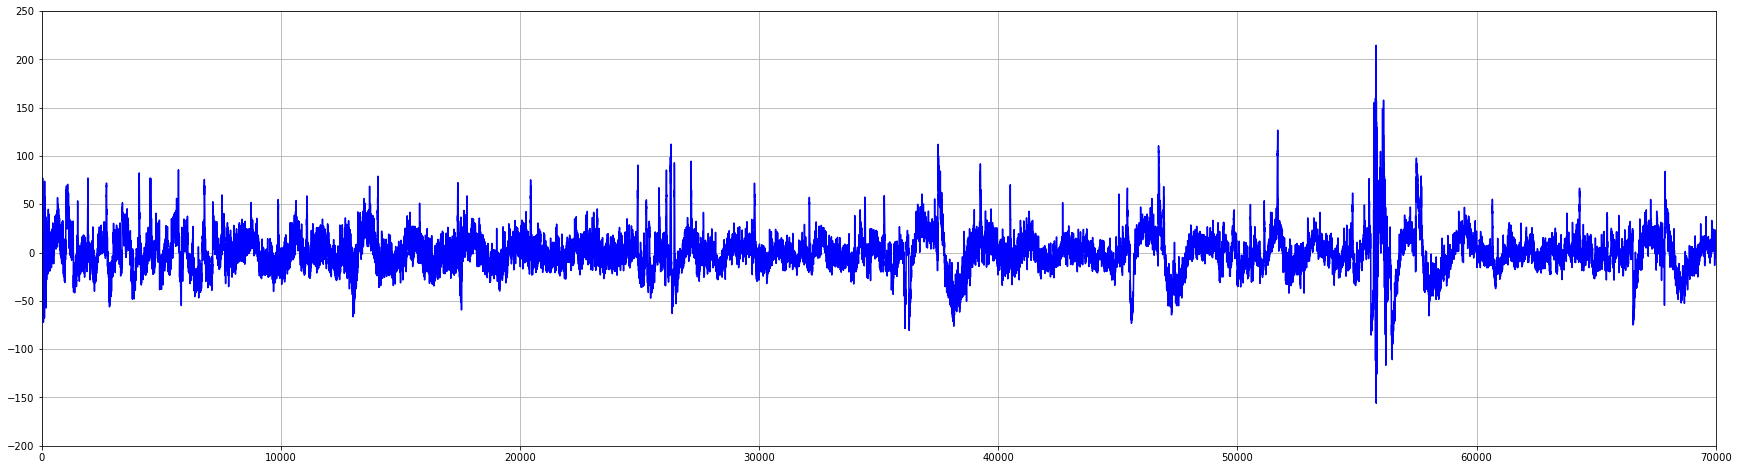

(None, None)

In [83]:
plt.figure(figsize=(30,8))
plt.plot(df_signal_original['sample'], df_signal_original[0], color[1])
plt.xlim([0,70000])
plt.ylim([-200,250]);
plt.grid(), plt.show()

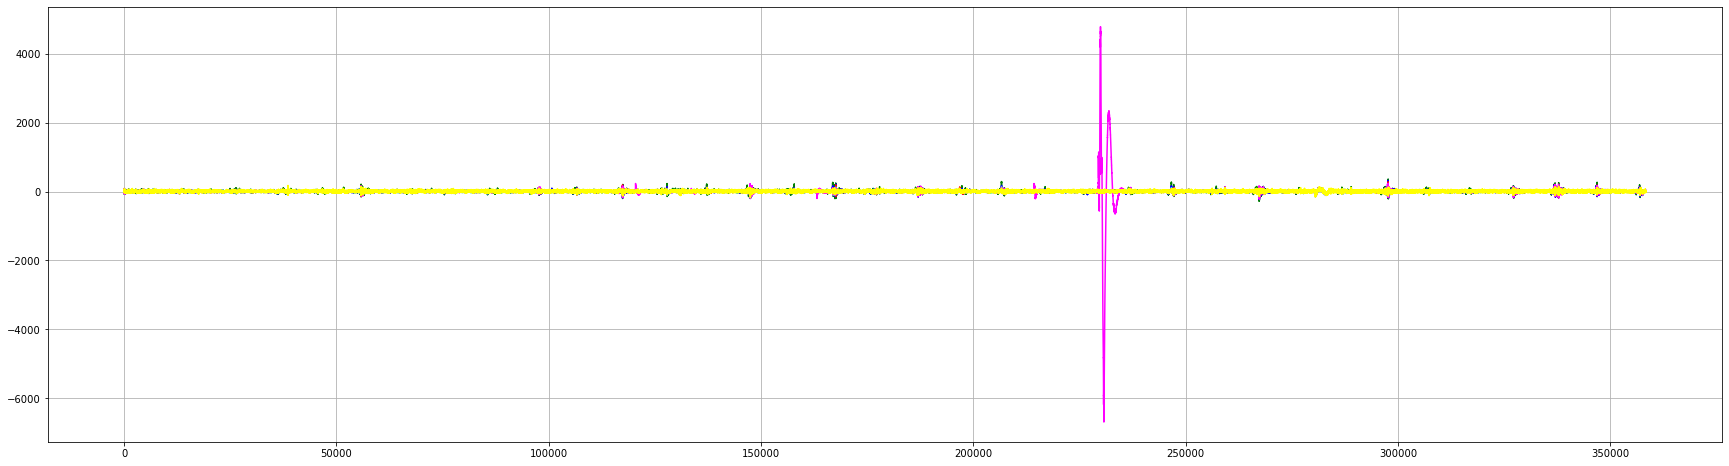

In [20]:
plt.figure(figsize=(30,8))
for i in range(0,6):
    plt.plot(df_mat25_data['sample'], df_mat25_data[i], color[i])
plt.grid()
plt.savefig("07 - P300-subject-25.jpg")
plt.show()

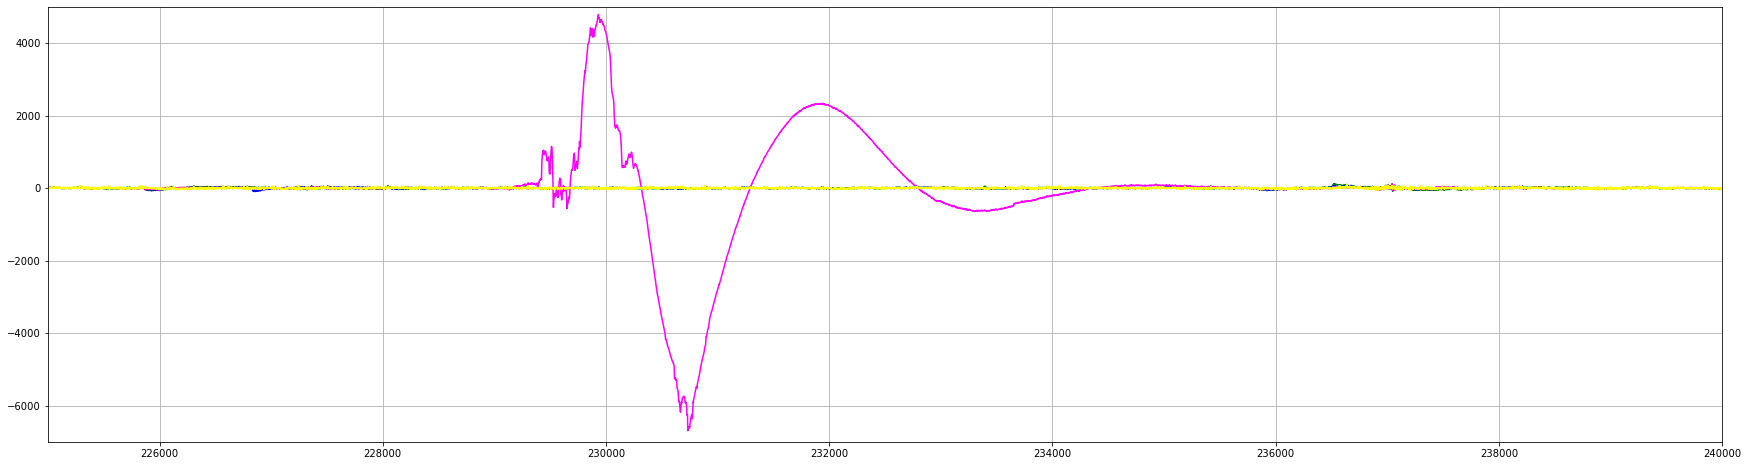

In [21]:
plt.figure(figsize=(30,8))
axes = plt.gca()
for i in range(0,6):
    plt.plot(df_mat25_data['sample'], df_mat25_data[i], color[i])
plt.ylim([-7000, 5000]);
plt.xlim([225000,240000])
plt.grid()
plt.savefig("08 - p300-subject-25-WINDOW01.jpg")
plt.show()

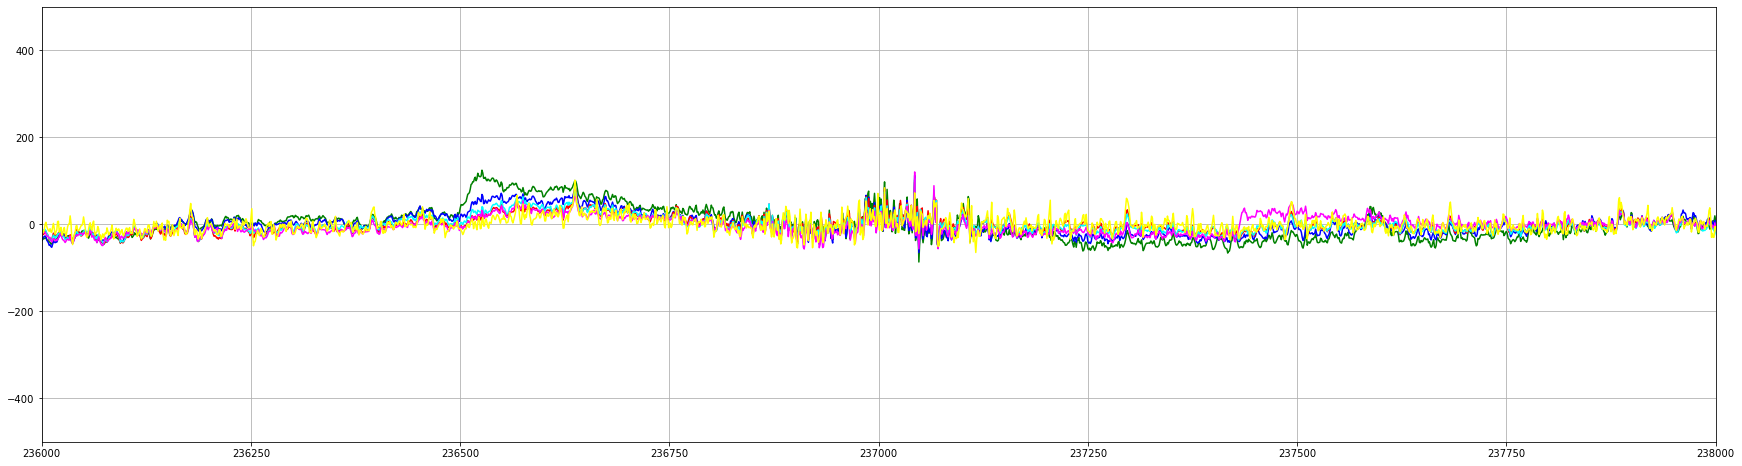

In [22]:
plt.figure(figsize=(30,8))
axes = plt.gca()
for i in range(0,6):
    plt.plot(df_mat25_data['sample'], df_mat25_data[i], color[i])
plt.ylim([-500, 500]);
plt.xlim([236000,238000])
plt.grid()
plt.savefig("04 - p300-subject-25-WINDOW02.jpg")
plt.show()

### *data.trial: Sample point where each of the 35 trials starts.*

https://www.kaggle.com/datasets/rramele/p300samplingdataset

In [40]:
# Trials
t_trials = mat['data'][0][0][3]
t_trials

array([[  7499,  17528,  27552,  37580,  47605,  57625,  67653,  77674,
         87662,  97732, 107754, 117778, 127809, 137840, 147834, 157865,
        167897, 177931, 187962, 197990, 208014, 218041, 228068, 238091,
        248117, 258144, 268169, 278194, 288221, 298248, 308272, 318297,
        328326, 338348, 348374]])

In [41]:
df_t_trials = pd.DataFrame(t_trials)
#df_t_trials['sample'] = df_signal.index
df_t_trials.head(3)

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,7499,17528,27552,37580,47605,57625,67653,77674,87662,97732,...,258144,268169,278194,288221,298248,308272,318297,328326,338348,348374


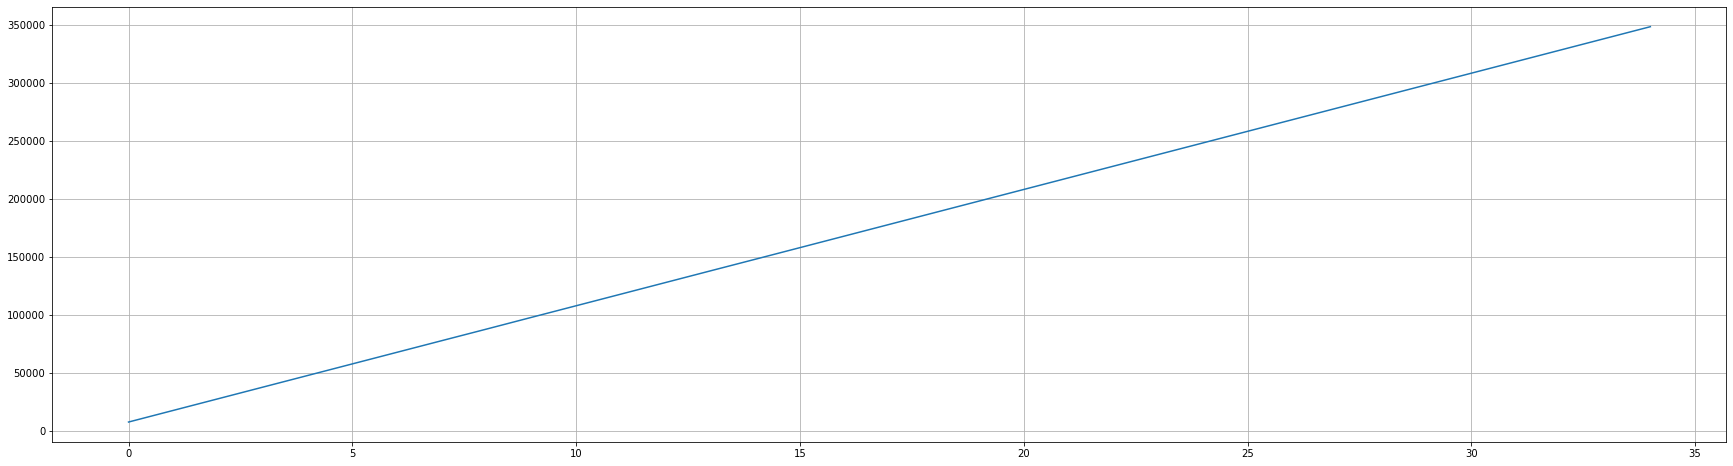

(None, None)

In [42]:
df_t_trials = pd.DataFrame(t_trials)
df_t_trials = df_t_trials.transpose()
df_t_trials['sample'] = df_t_trials.index
df_t_trials.head()
plt.figure(figsize=(30,8))
plt.plot(df_t_trials['sample'], df_t_trials[0])
plt.grid(), plt.show()

### *data.flash: Sample point where each flashing starts (sample point id, duration, stimulation, hit/nohit)* 
data.flash: punto de muestra donde comienza cada parpadeo (identificación del punto de muestra, duración, estimulación, hit/nohit)  
Nota: En la función DrugSignal sólo usa el canal 0 y el 3. Por ahora los otros canales no me interesan.

https://www.kaggle.com/datasets/rramele/p300samplingdataset

In [43]:
# Flash matrix
t_flash = mat['data'][0][0][4]
#t_flash
df_t_flash = to_df(t_flash)
df_t_flash.head(5)

,0,1,2,3,sample
0,7499,33,11,1,0
1,7564,32,1,1,1
2,7627,33,9,1,2
3,7690,30,6,1,3
4,7750,33,8,2,4


In [44]:
df_t_flash.describe()

,0,1,2,3,sample
count,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000
mean,181668.002143,30.970238,6.500000,1.166667,2099.500000
std,101288.416332,3.861229,3.452464,0.372722,1212.579894
min,7499.000000,9.000000,1.000000,1.000000,0.000000
25%,93340.750000,30.000000,3.750000,1.000000,1049.750000
50%,181672.500000,32.000000,6.500000,1.000000,2099.500000
75%,269993.000000,32.000000,9.250000,1.000000,3149.250000
max,355828.000000,111.000000,12.000000,2.000000,4199.000000


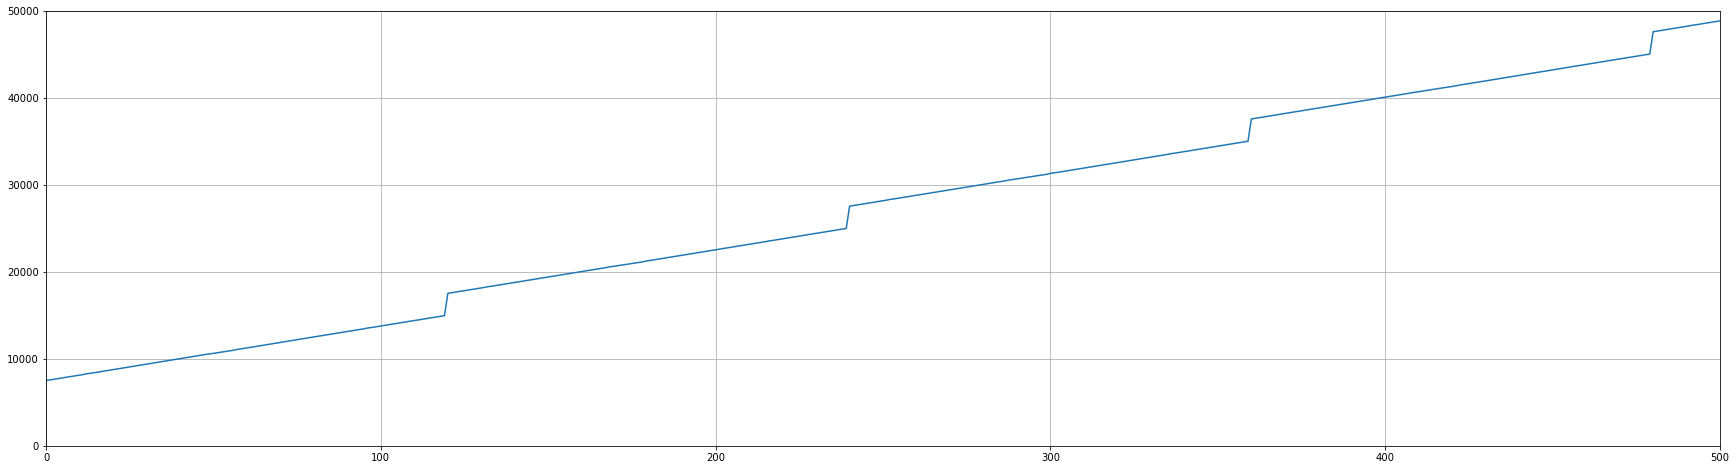

(None, None)

In [45]:
plt.figure(figsize=(30,8))
plt.plot(df_t_flash['sample'], df_t_flash[0])
plt.xlim([0,500])
plt.ylim([0,50000]);
plt.grid(), plt.show()

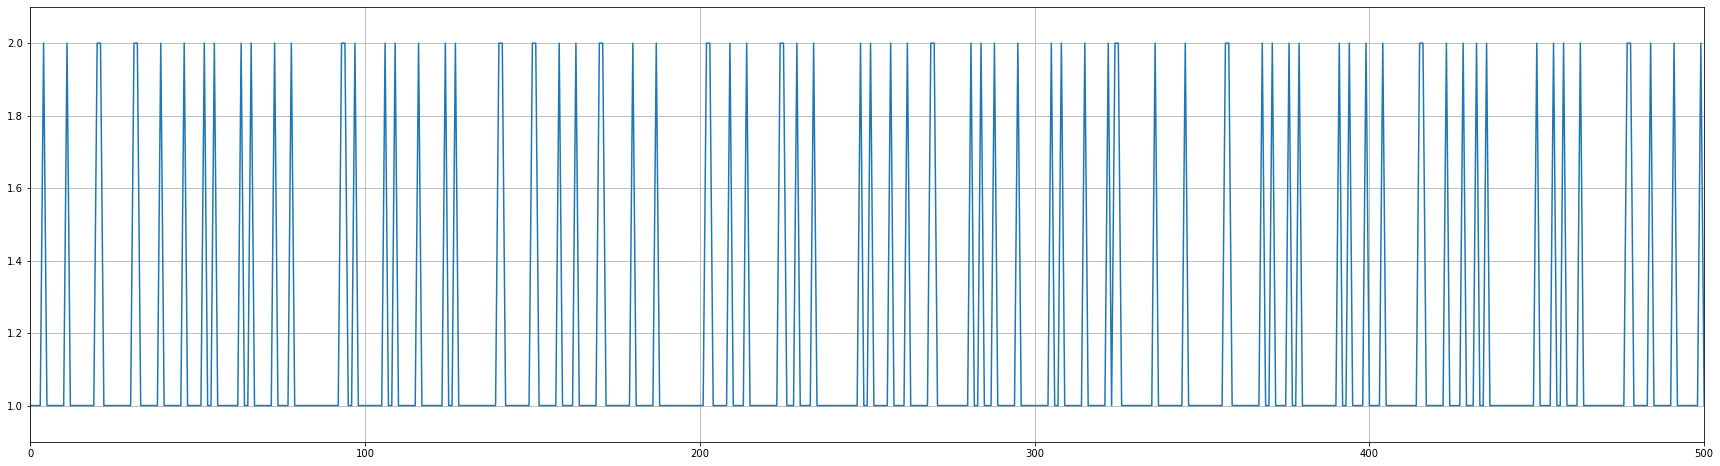

(None, None)

In [46]:
plt.figure(figsize=(30,8))
plt.plot(df_t_flash['sample'], df_t_flash[3])
plt.xlim([0,500])
plt.ylim([0.9,2.1]);
plt.grid(), plt.show()

In [35]:
signal_ALEX2 = to_df(signal)
signal_ALEX2.head(10)

,0,1,2,3,4,5,6,7,sample
0,-25.841171,-10.557603,-6.211982,-15.843910,-13.558990,20.122635,-11.946080,6.265652,0
1,-34.338673,-18.944792,-17.603668,-26.940290,-23.392313,-17.507841,-31.759108,-16.000412,1
2,-37.689247,-19.064447,-18.308565,-25.747719,-21.724098,-18.072618,-28.811285,-11.629916,2
3,-24.009695,-6.639306,-11.457250,-11.021503,-1.366220,-5.843951,-10.881763,3.213532,3
4,-14.699684,-0.977608,-3.606690,1.438218,18.299120,10.070486,9.120290,27.182615,4
5,-6.905956,4.759079,1.665619,6.454340,26.683174,12.585777,13.611430,25.152113,5
6,25.883667,36.015572,28.016043,32.570457,60.801224,29.851191,27.427492,27.701725,6
7,-14.083708,-4.600820,1.976110,-0.446925,20.095476,3.899734,11.805900,8.699254,7
8,-42.580444,-24.832602,-5.260470,-11.612387,1.500922,5.543776,3.472059,6.472950,8
9,-32.301765,-10.954214,5.330559,2.850624,10.216281,8.052427,5.542897,17.444468,9


In [66]:
DrugSignal_ALEX = DrugSignal_ALEX(signal, t_flash)
df_DrugSignal_ALEX = to_df(DrugSignal_ALEX)
df_DrugSignal_ALEX.head(20)
#df_signal_ALEX.describe()

,0,1,2,3,4,5,6,7,sample
0,-25.841171,-10.557603,-6.211982,-15.843910,-13.558990,20.122635,-11.946080,6.265652,0
1,-34.338673,-18.944792,-17.603668,-26.940290,-23.392313,-17.507841,-31.759108,-16.000412,1
2,-37.689247,-19.064447,-18.308565,-25.747719,-21.724098,-18.072618,-28.811285,-11.629916,2
3,-24.009695,-6.639306,-11.457250,-11.021503,-1.366220,-5.843951,-10.881763,3.213532,3
4,-14.699684,-0.977608,-3.606690,1.438218,18.299120,10.070486,9.120290,27.182615,4
5,-6.905956,4.759079,1.665619,6.454340,26.683174,12.585777,13.611430,25.152113,5
6,25.883667,36.015572,28.016043,32.570457,60.801224,29.851191,27.427492,27.701725,6
7,-14.083708,-4.600820,1.976110,-0.446925,20.095476,3.899734,11.805900,8.699254,7
8,-42.580444,-24.832602,-5.260470,-11.612387,1.500922,5.543776,3.472059,6.472950,8
9,-32.301765,-10.954214,5.330559,2.850624,10.216281,8.052427,5.542897,17.444468,9


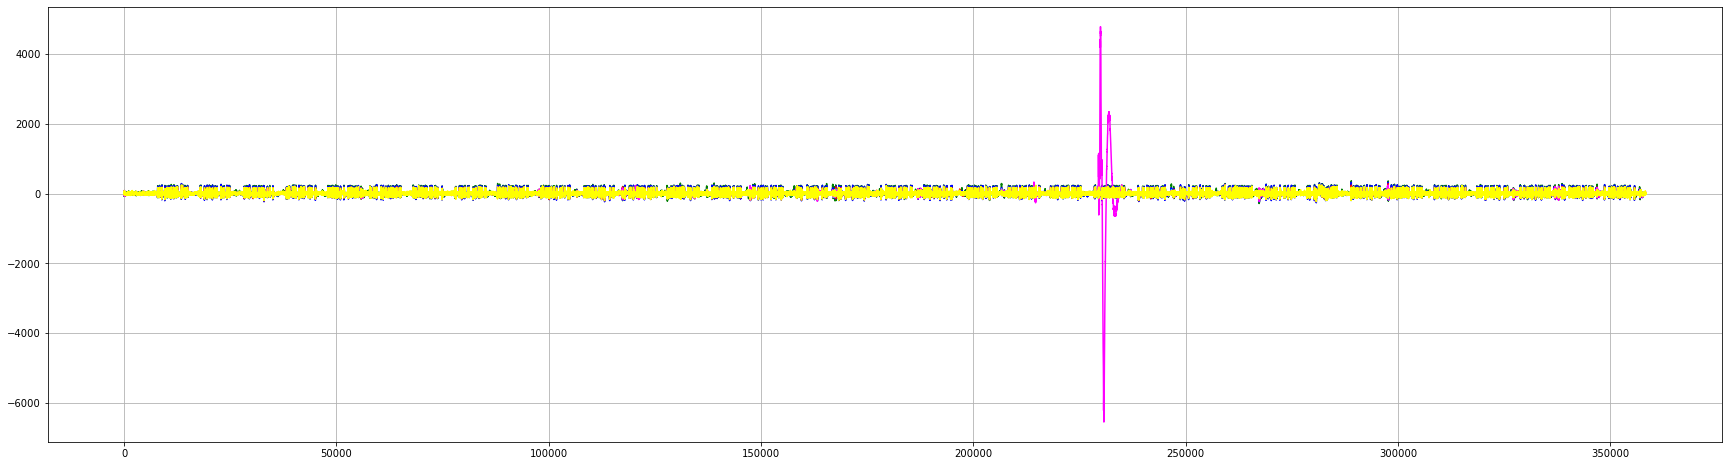

(None, None)

In [77]:
plt.figure(figsize=(30,8))
for i in range(0,6):
    plt.plot(df_DrugSignal_ALEX['sample'], df_DrugSignal_ALEX[i], color[i])
plt.grid(), plt.show()

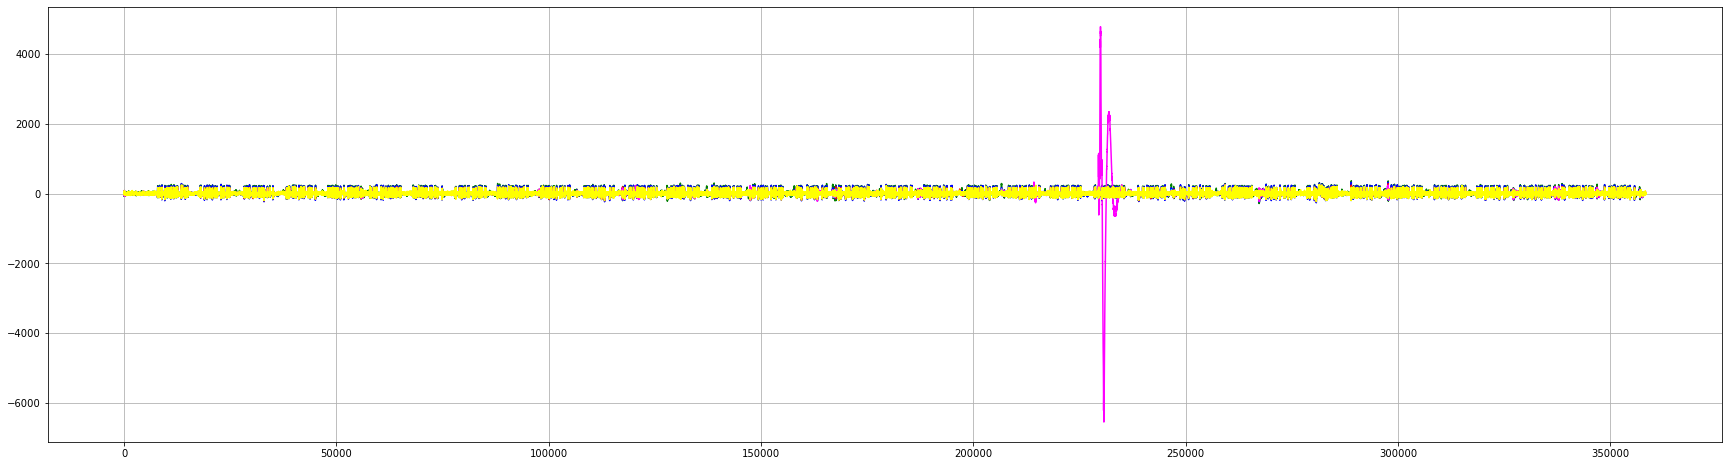

(None, None)

In [76]:
plt.figure(figsize=(30,8))
for i in range(0,6):
    plt.plot(df_signal_original['sample'], df_signal_original[i], color[i])
plt.grid(), plt.show()

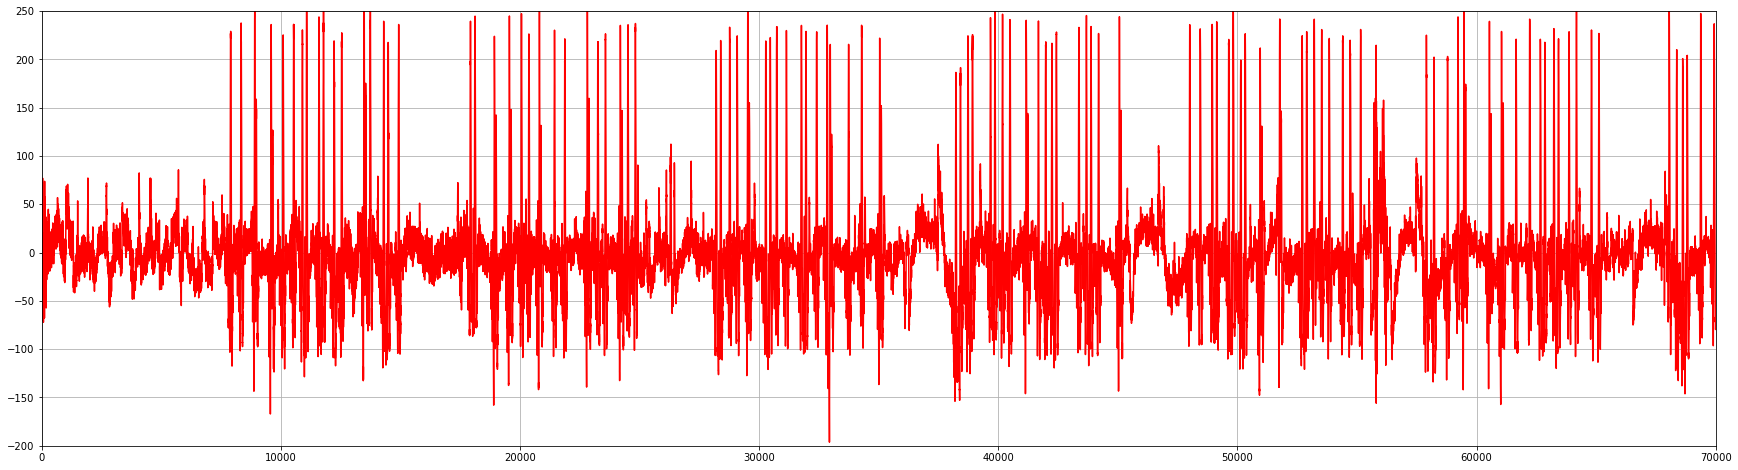

(None, None)

In [85]:
plt.figure(figsize=(30,8))
plt.plot(df_DrugSignal_ALEX['sample'], df_DrugSignal_ALEX[0], color[2])
plt.xlim([0,70000])
plt.ylim([-200,250]);
plt.grid(), plt.show()

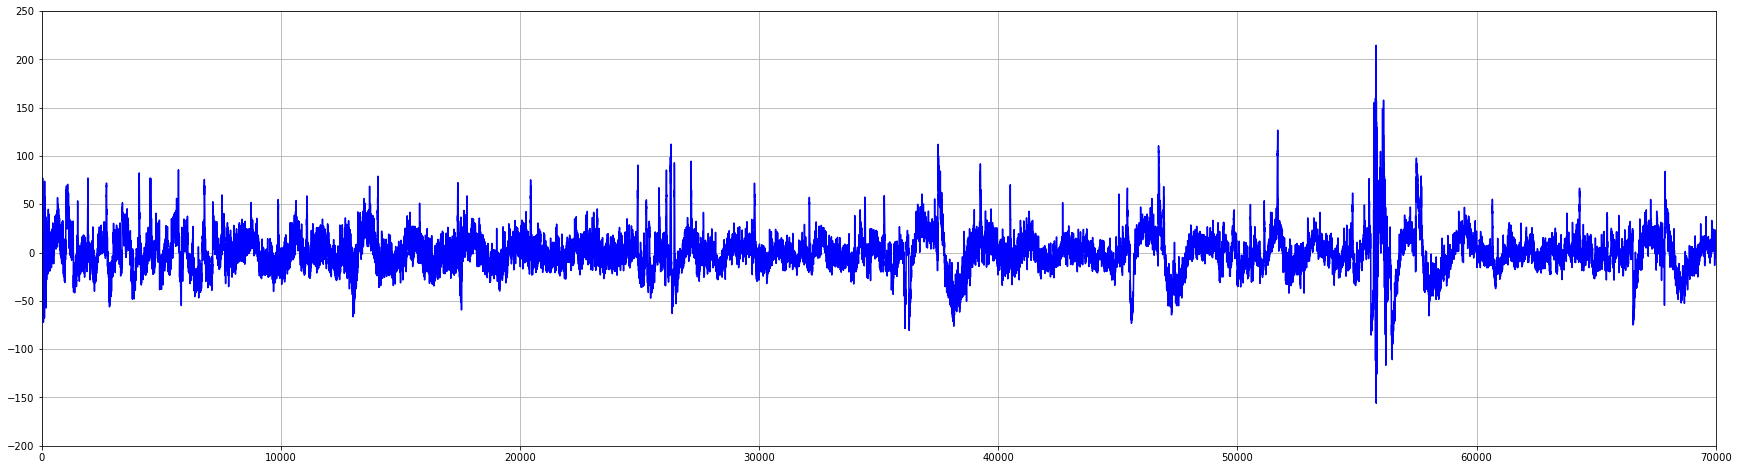

(None, None)

In [84]:
plt.figure(figsize=(30,8))
plt.plot(df_signal_original['sample'], df_signal_original[0], color[1])
plt.xlim([0,70000])
plt.ylim([-200,250]);
plt.grid(), plt.show()

=================================================================================================================

=================================================================================================================

=================================================================================================================

=================================================================================================================

=================================================================================================================